In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
from collections import defaultdict
import seaborn as sns

# Variables for Selenium
BINARY_LOCATION = '/home/lorenzos/.local/bin/chrome-linux64/chrome'
EXECUTABLE_PATH = '/home/lorenzos/.local/bin/chromedriver-linux64/chromedriver'

# Some help functions
def sort_dict(x): return dict(sorted(x.items(), key=lambda item: item[1], reverse=True))

ModuleNotFoundError: No module named 'selenium'

In [2]:
!pip install selenium

  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached trio-0.30.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached trio_websocket-0.12.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached certifi-2025.7.14-py3-none-any.whl.metadata (2.4 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached websocket_client-1.8.0-py3-none-any.whl.metadata (8.0 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached outcome-1.3.0.post0-py2.py3-none-any.whl.metadata (2.6 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl.metadata (13 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 4.0 MB/s

In [ ]:
Wallet = {'LU2195226068': 898.75, #
          'IE000J0LN0R5': 394.20,
          'LU0908500753': 261.70,
          } # iShares Core MSCI Emerging Markets IMI UCITS ETF (Acc)

: 

### Get ETF Data

In [3]:
def get_data(wallet, show_more_button = True):

    data = {}

    for isin in wallet:

        etf_data = get_basics_data(isin)
        
        if show_more_button:
            etf_data['countries'] = get_show_more_button_data(isin, 'Countries')
            etf_data['sectors'] = get_show_more_button_data(isin, 'Sectors')

        data[isin] = etf_data

    return data

def get_basics_data(isin):
    
    url = f"https://www.justetf.com/en/etf-profile.html?isin={isin}"
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/114.0.0.0 Safari/537.36"
        )
    }

    resp = requests.get(url, headers=headers)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    # Locate the "Basics" section and then find the "Data" table
    basics_header = soup.find("h2", string=lambda text: text and "Basics" in text)
    data_table = basics_header.find_next("table") if basics_header else None

    data = {}
    if data_table:
        for row in data_table.find_all("tr"):
            cols = row.find_all(["td", "th"])
            if len(cols) == 2:
                key = cols[0].get_text(strip=True)
                value = cols[1].get_text(strip=True)
                data[key] = value

    return data

def get_show_more_button_data(isin, heading):

    assert heading=='Countries' or heading=='Sectors', 'Invalid heading!'

    options = webdriver.ChromeOptions()
    options.binary_location = BINARY_LOCATION #'/usr/bin/brave-browser'
    options.add_argument('--headless=new')
    options.add_argument('--disable-gpu')
    service = webdriver.ChromeService(executable_path=EXECUTABLE_PATH)
    driver = webdriver.Chrome(options=options, service=service)

    basic_url = 'https://www.justetf.com/en/etf-profile.html?isin='
    driver.get(basic_url+isin)

    wait = WebDriverWait(driver, 10)
    container = wait.until(EC.presence_of_element_located((By.XPATH, f"//h3[normalize-space()='{heading}']/ancestor::div[1]")))

    show_more_button = container.find_element(By.TAG_NAME, "a")

    driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", show_more_button)
    driver.execute_script("arguments[0].click();", show_more_button)
    sleep(0.1)

    table = container.find_element(By.TAG_NAME, "table")
    rows = table.find_elements(By.TAG_NAME, "tr")

    data = []
    for row in rows:
        cells = row.find_elements(By.TAG_NAME, "td")
        if len(cells) >= 2:
            country = cells[0].text.strip()
            percentage = cells[1].find_element(By.TAG_NAME, "span").text.strip()
            data.append((country, percentage))
    
    return data

In [4]:
data_etf = get_data(wallet=Wallet, show_more_button=True)

### Compute wallet data

In [17]:
def aggregate_wallet_data(Wallet, data):
    def sort_dict(d):
        return dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

    # Countries
    countries = defaultdict(float)
    for isin in Wallet:
        for key, value in data[isin]['countries']:
            countries[key] += Wallet[isin] / 100 * float(value[:-1])
    countries = sort_dict(countries)

    # Continents
    continent_map = {
        'North America': ['United States', 'Canada', 'Mexico'],
        'South America': ['Brazil'],
        'Europe': ['United Kingdom', 'France', 'Germany', 'Netherlands', 'Switzerland'],
        'Africa': ['South Africa'],
        'Asia': ['Saudi Arabia', 'India', 'China', 'Taiwan', 'Japan', 'South Korea', 'Malaysia'],
        'Oceania': ['Australia'],
        'Mix': ['Other']
    }
    country_to_continent = {country: continent for continent, countries_list in continent_map.items() for country in countries_list}
    continents = defaultdict(float)
    for isin in Wallet:
        for country, percentage in data[isin]['countries']:
            continent = country_to_continent.get(country, country)
            continents[continent] += Wallet[isin] / 100 * float(percentage[:-1])
    continents = sort_dict(continents)

    # Sectors
    sectors = defaultdict(float)
    for isin in Wallet:
        for key, value in data[isin]['sectors']:
            sectors[key] += Wallet[isin] / 100 * float(value[:-1])
    sectors = sort_dict(sectors)

    # Providers
    providers = defaultdict(float)
    for isin in Wallet:
        providers[data[isin]['Fund Provider']] += Wallet[isin]

    # Domiciles
    domiciles = defaultdict(float)
    for isin in Wallet:
        domiciles[data[isin]['Fund domicile']] += Wallet[isin]

    # Fund sizes
    sizes, currencies, units = [], [], []
    for isin in Wallet:
        currency, value, unit = data[isin]['Fund size'].split()
        currencies.append(currency)
        units.append(unit)
        sizes.append(float(value.replace(",", ".")))
    assert all(c == currencies[0] for c in currencies), "Different currencies found."
    assert all(u == units[0] for u in units), "Different units found."

    # TER
    ters = [float(data[isin]['Total expense ratio'].split()[0].replace('%', '')) for isin in Wallet]

    # Fund currencies
    fund_currencies = defaultdict(float)
    for isin in Wallet:
        fund_currencies[data[isin]['Fund currency']] += Wallet[isin]

    return {
        'countries': countries,
        'continents': continents,
        'sectors': sectors,
        'providers': providers,
        'domiciles': domiciles,
        'fund_sizes': sizes,
        'currency': currencies[0],
        'unit': units[0],
        'ter': ters,
        'fund_currencies': fund_currencies
    }

In [18]:
wallet_data = aggregate_wallet_data(Wallet, data_etf)

### Draw Dashboard

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch
import matplotlib.patheffects as path_effects

def plot_wallet(wallet_data):
    
    # Set modern dark theme
    plt.style.use('dark_background')
    
    # Create figure with custom grid layout
    fig = plt.figure(figsize=(20, 14), dpi=150)
    fig.patch.set_facecolor('#0a0a0a')
    
    # Define modern color palettes
    primary_colors = ['#00d4ff', '#ff6b9d', '#a8e6cf', '#ffd93d', '#ff8c42', '#6c5ce7', '#fd79a8', '#00b894']
    gradient_colors = ['#667eea', '#764ba2', '#f093fb', '#f5576c', '#4facfe', '#00f2fe', '#43e97b', '#38f9d7']
    dark_bg = '#1a1a1a'
    card_bg = '#2a2a2a'
    
    # Create custom grid layout with more spacing
    gs = gridspec.GridSpec(4, 6, figure=fig, hspace=0.6, wspace=0.4,
                          left=0.08, right=0.94, top=0.9, bottom=0.12)
    
    def create_modern_card(ax, title, bg_color=card_bg):
        """Create a modern card-like appearance for each subplot"""
        ax.set_facecolor(bg_color)
        
        # Add subtle border glow effect
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Add title with modern styling
        title_text = ax.text(0.5, 1.15, title, transform=ax.transAxes, 
                           fontsize=14, weight='bold', ha='center', va='bottom',
                           color='white', fontfamily='monospace')
        title_text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
        
        # Add subtle grid
        ax.grid(True, alpha=0.1, linestyle='-', linewidth=0.5)
        
        return ax
    
    def modern_bar_plot(ax, title, data, color_palette=primary_colors):
        """Create modern bar plot with gradient-like styling"""
        create_modern_card(ax, title)
        
        values = list(data.values())
        keys = list(data.keys())
        
        # Create bars with modern styling
        bars = ax.bar(keys, values, color=color_palette[:len(data)], 
                     edgecolor='white', linewidth=1.5, alpha=0.9)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + max(values) * 0.01,
                   f'{value:.1f}' if isinstance(value, float) else f'{value}',
                   ha='center', va='bottom', fontsize=10, weight='bold', color='white')
        
        # Style the axes
        ax.tick_params(axis='x', rotation=45, labelsize=9, colors='white', pad=8)
        ax.tick_params(axis='y', labelsize=10, colors='white')
        ax.set_ylim(0, max(values) * 1.2)
        
        # Ensure tick labels don't overlap with other elements
        plt.setp(ax.get_xticklabels(), ha='right')
        
        # Add subtle background pattern
        ax.set_axisbelow(True)
        
        return bars
    
    def modern_pie_plot(ax, title, data, colors=gradient_colors):
        """Create modern donut chart with enhanced styling"""
        create_modern_card(ax, title)
        
        # Create donut chart instead of pie
        wedges, texts, autotexts = ax.pie(data.values(), labels=data.keys(), 
                                         autopct='%1.1f%%', startangle=90,
                                         colors=colors[:len(data)], 
                                         wedgeprops={'width': 0.6, 'edgecolor': 'white', 'linewidth': 2},
                                         textprops={'fontsize': 10, 'weight': 'bold', 'color': 'white'},
                                         pctdistance=0.85)
        
        # Style the percentage text
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(9)
            autotext.set_weight('bold')
        
        # Add center circle for donut effect
        centre_circle = plt.Circle((0, 0), 0.40, fc='#2a2a2a', linewidth=2, edgecolor='white')
        ax.add_artist(centre_circle)
        
        ax.axis('equal')
        
        return wedges
    
    def modern_line_plot(ax, title, data, color='#00d4ff', ylabel=''):
        """Create modern line plot with area fill"""
        create_modern_card(ax, title)
        
        x = range(len(data))
        
        # Create line plot with area fill
        ax.plot(x, data, 'o-', color=color, linewidth=3, markersize=8, 
               markerfacecolor=color, markeredgecolor='white', markeredgewidth=2)
        
        # Add area fill with gradient effect
        ax.fill_between(x, data, alpha=0.3, color=color)
        
        # Add value labels
        for i, value in enumerate(data):
            ax.text(i, value + (max(data) - min(data)) * 0.05, f'{value:.2f}',
                   ha='center', va='bottom', fontsize=9, weight='bold', color='white')
        
        ax.set_xticks(x)
        ax.set_xticklabels([f'ETF {i+1}' for i in x], fontsize=10, color='white')
        ax.tick_params(axis='y', labelsize=10, colors='white')
        ax.set_ylabel(ylabel, fontsize=11, color='white', weight='bold')
        
        # Set limits with padding
        y_range = max(data) - min(data)
        ax.set_ylim(min(data) - y_range * 0.1, max(data) + y_range * 0.2)
        
        return ax
    
    # Create subplots with new layout
    # Left column: Bar plots
    ax1 = fig.add_subplot(gs[0, :4])  # Countries - top bar plot
    ax2 = fig.add_subplot(gs[1, :4])  # Continents - middle bar plot
    ax3 = fig.add_subplot(gs[2, :4])  # Sectors - bottom bar plot
    
    # Right column: Pie charts
    ax4 = fig.add_subplot(gs[0, 4:])  # Fund Currencies - top pie
    ax5 = fig.add_subplot(gs[1, 4:])  # Providers - middle pie
    ax6 = fig.add_subplot(gs[2, 4:])  # Fund Domiciles - bottom pie
    
    # Bottom row: Line plots side by side
    ax7 = fig.add_subplot(gs[3, :3])  # Fund Sizes - left
    ax8 = fig.add_subplot(gs[3, 3:])  # TER - right
    
    # Create the plots with modern styling
    modern_bar_plot(ax1, 'Geographic Distribution by Countries', wallet_data['countries'], primary_colors)
    modern_bar_plot(ax2, 'Continental Allocation', wallet_data['continents'], gradient_colors)
    modern_bar_plot(ax3, 'Sector Diversification', wallet_data['sectors'], primary_colors)
    
    modern_pie_plot(ax4, 'Fund Currencies', wallet_data['fund_currencies'], gradient_colors)
    modern_pie_plot(ax5, 'Fund Providers', wallet_data['providers'], primary_colors)
    modern_pie_plot(ax6, 'Fund Domiciles', wallet_data['domiciles'], gradient_colors)
    
    modern_line_plot(ax7, 'Fund Sizes', wallet_data['fund_sizes'], '#ff6b9d', 
                    f"{wallet_data['unit']} {wallet_data['currency']}")
    
    modern_line_plot(ax8, 'Total Expense Ratio (TER) Analysis', wallet_data['ter'], '#a8e6cf', '% p.a.')
    
    # Add main title with modern styling
    main_title = fig.suptitle("ETF Wallet Dashboard", 
                             fontsize=24, weight='bold', color='white', 
                             fontfamily='monospace', y=0.96)
    main_title.set_path_effects([path_effects.withStroke(linewidth=4, foreground='#333333')])
 
    # Add decorative elements
    # Top border line
    fig.add_artist(patches.Rectangle((0.06, 0.94), 0.88, 0.005, 
                                   facecolor='#00d4ff', transform=fig.transFigure))
    
    # Bottom border line
    fig.add_artist(patches.Rectangle((0.06, 0.06), 0.88, 0.005, 
                                   facecolor='#ff6b9d', transform=fig.transFigure))
    
    plt.show()


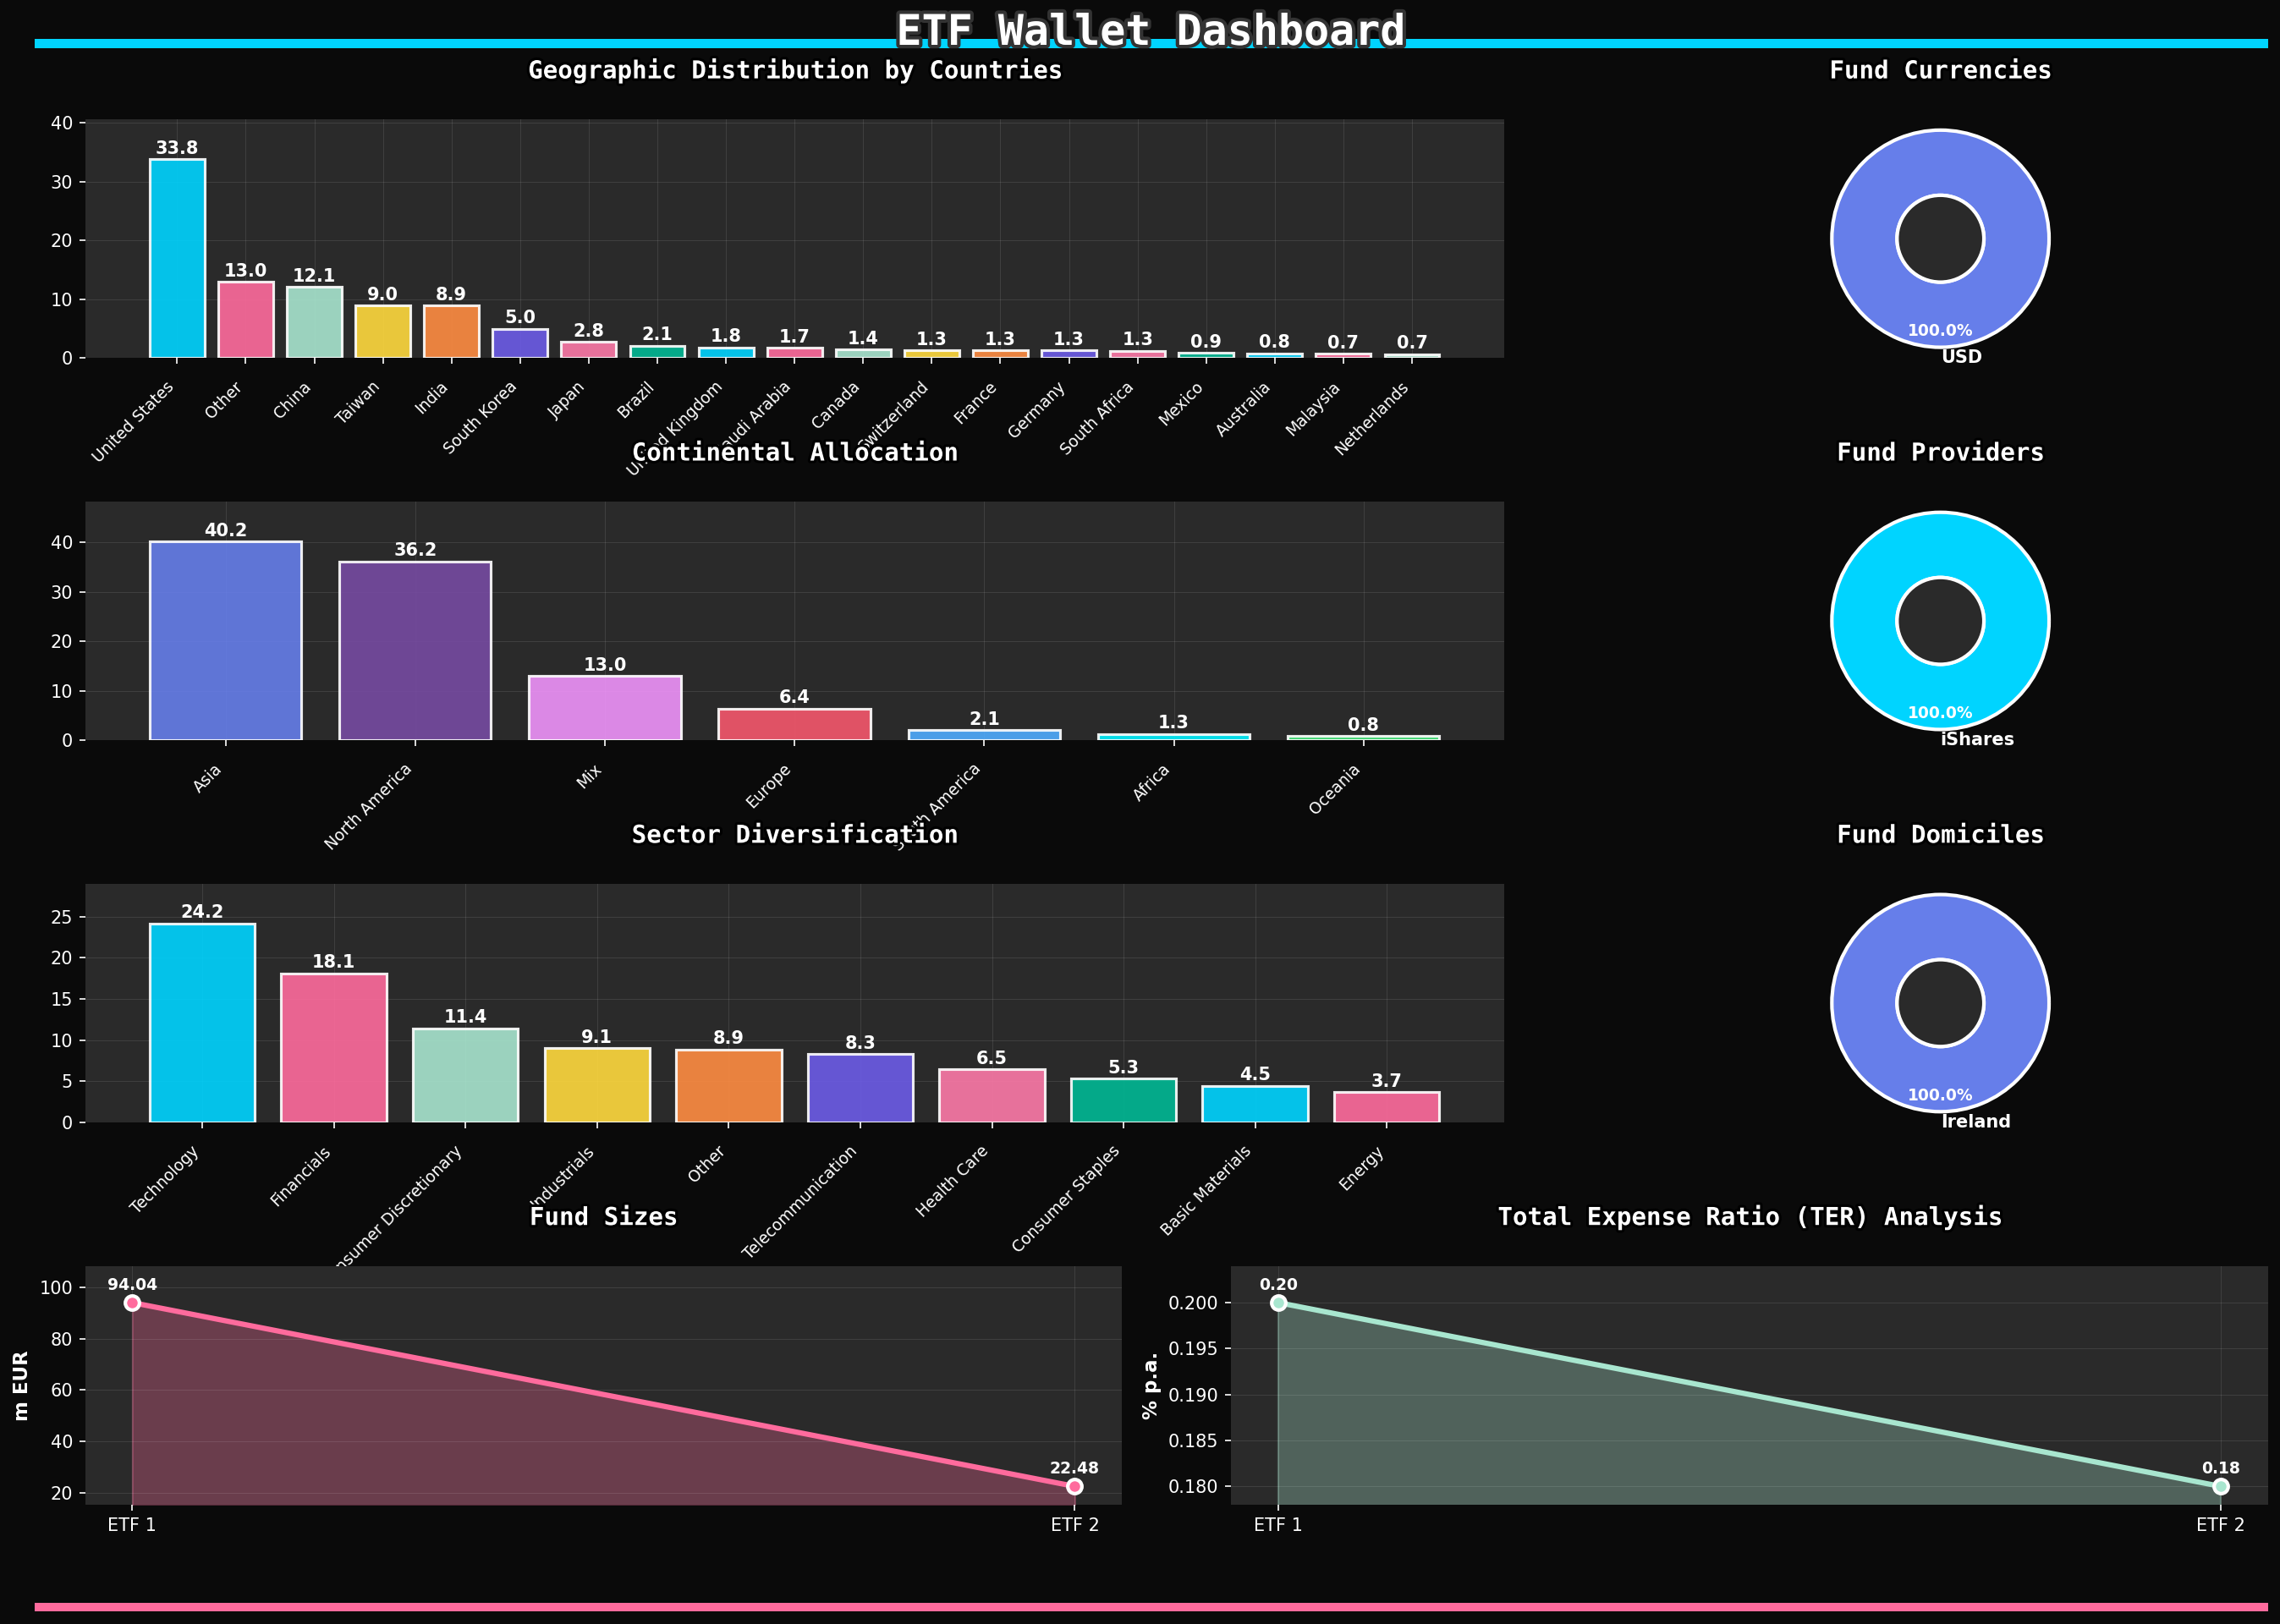

In [44]:
%matplotlib inline
plot_wallet(wallet_data)